In [1]:
from torch.backends import cudnn
import torch
from transformers.utils import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from torchvision.datasets import ImageFolder

import torchvision
import sys

sys.path.append('../..')
import torchvision.transforms.v2 as transforms


normalize = transforms.Normalize(
    mean=IMAGENET_DEFAULT_MEAN,
    std=IMAGENET_DEFAULT_STD,
)

train_augs = transforms.Compose(
    [
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(),
        normalize,
    ]
)


test_augs = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToImageTensor(),
        transforms.ConvertImageDtype(),
        normalize,
    ]
)
train_set = ImageFolder('/path/to/dataset/train', transform=train_augs)
test_set = ImageFolder('/path/to/dataset/val', transform=test_augs)
train_set.class_to_idx

{'coal': 0, 'gangue': 1, 'rock': 2}

In [2]:
from torch import nn
from ic.train import utils


config = {
    "n_epochs": 2,
    "data_loader": {"batch_size": 120, "num_workers": 16, "pin_memory": True},
    "optimizer": "Adam",
    "optim_hparas": {"lr": 1e-3, "weight_decay": 1e-4},
    "criterion": nn.CrossEntropyLoss(),
    "weights": False,
    "freeze_backbone": False,
}

# if not config["weights"]:
#     config["n_epochs"] = 100

if not config["weights"] and config["freeze_backbone"]:
    raise ValueError("If weights is None, freeze_backbone must be False.")

if config["freeze_backbone"]:
    # print("Remember increase batch size if you freeze backbone.")
    config["data_loader"]["batch_size"] = 1200

config["optim_hparas"]["lr"] = (
    1e-5 if config["weights"] else config["optim_hparas"]["lr"]
)
len(train_set), len(test_set)

(1200, 150)

In [3]:
from ic.models import *


layer = 169
model = DenseNet(layer, config["weights"], num_classes=3)
# model = HuggingFaceViT(config['weights'], num_labels=3)
last_layer = utils.get_model_last_layer_name(model)
if config["freeze_backbone"]:
    for name, param in model.named_parameters():
        if last_layer not in name:
            param.requires_grad = False

loss 0.903, train acc 0.628, test acc 0.467
Saved model to ./DenseNet.pth.tar . Call `torch.nn.modules.utils.consume_prefix_in_state_dict_if_present(ddp_state_dict, '{prefix}')` to remove the prefix before loading the state dict.


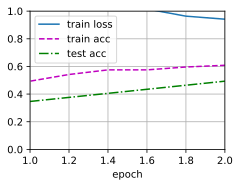

In [4]:
cudnn.benchmark = True
model.cpu()
if __name__ == '__main__':
    utils.train_distributed("tcp://localhost:23456", config, model, train_set, test_set)

In [5]:
from torch.nn.modules.utils import consume_prefix_in_state_dict_if_present

ckpt_name = model.__class__.__name__
ckpt = torch.load(f'{ckpt_name}.pth.tar', map_location='cpu')
consume_prefix_in_state_dict_if_present(ckpt, '_orig_mod.module.')
model.load_state_dict(ckpt)

<All keys matched successfully>

In [6]:
model.cuda().eval()
_, test_loader = utils.create_data_loaders(config, train_set, test_set)
y_true, y_pred = utils.model_y_true_y_pred(model, test_loader, "cuda", True)

  0%|          | 0/2 [00:00<?, ?it/s]

Accuracy: 0.480, F1: 0.479


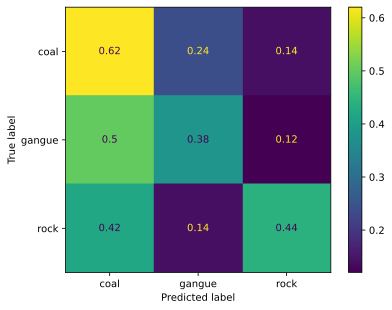

In [7]:
from sklearn.metrics import *
import matplotlib.pyplot as plt
from d2l import torch as d2l

d2l.use_svg_display()
acc, f1 = accuracy_score(y_true, y_pred), f1_score(y_true, y_pred, average='weighted')
str_acc = str(f"{acc * 100:.1f}")
str_f1 = str(f"{f1 * 100:.1f}")
fig_name = f"fc_{str_acc}_{str_f1}.svg" if not config[
    "freeze_backbone"] else f"freeze_fc_{str_acc}_{str_f1}.svg"
model_name = "fc.tar" if not config["freeze_backbone"] else "freeze_fc.tar"

# !mv {ckpt_name}.pth.tar {model_name}

ConfusionMatrixDisplay.from_predictions(y_true, y_pred, normalize='true', display_labels=train_set.classes)
print(f'Accuracy: {acc:.3f}, F1: {f1:.3f}')
# plt.savefig(fig_name)
plt.show()